# Geodesic Simulations Around Black Holes
## FIXED VERSION - Corrected Centrifugal Term

This notebook demonstrates photon and massive particle trajectories around both non-rotating (Schwarzschild) and rotating (Kerr) black holes using numerical integration of the geodesic equations.

**Author:** Fynn Hufler  
**Date:** December 2nd, 2025  
**Fixed:** Corrected sign error in geodesic equation

---

### Table of Contents
1. [Setup and Imports](#setup)
2. [Schwarzschild Black Holes](#schwarzschild)
3. [Kerr Black Holes: Simulations](#kerr-sims)
4. [Comparative Analysis](#comparison)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
import sys

sys.path.append('../src/')
warnings.filterwarnings('ignore')

# Import the FIXED geodesic simulator
from geodesics import (
    SchwarzschildMetric, 
    KerrMetric,
    GeodesicSimulation,
    Trajectory
)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

print("Geometric units: G = c = 1")
print("Using FIXED geodesic simulator (corrected centrifugal term)")

Geometric units: G = c = 1
Using FIXED geodesic simulator (corrected centrifugal term)


---
## 1. Schwarzschild Black Holes <a id="schwarzschild"></a>

The **Schwarzschild metric** describes a non-rotating, spherically symmetric black hole.

### Key Features

- **Event Horizon:** $r_s = 2M$ — the point of no return
- **Photon Sphere:** $r_{ph} = 3M$ — unstable circular orbits for light
- **Critical Impact Parameter:** $b_{crit} = \sqrt{27}M \approx 5.196M$ for photon capture
- **ISCO (massive particles):** $r_{ISCO} = 6M$ — innermost stable circular orbit

### The Fix

The original code had a **sign error** in the geodesic equation. The centrifugal term should be:

$$\frac{d^2r}{d\tau^2} = \ldots + (r-2M)\left(\frac{d\phi}{d\tau}\right)^2$$

The **positive** sign represents the outward-pushing centrifugal force!

In [4]:
# Initialize Schwarzschild metric
M = 1.0
metric_sch = SchwarzschildMetric(mass=M)
sim_sch = GeodesicSimulation(metric_sch)

print("Schwarzschild Black Hole Parameters:")
print(f"  Mass M = {M}")
print(f"  Schwarzschild radius r_s = {metric_sch.r_s:.2f} M")
print(f"  Photon sphere r_ph = {metric_sch.r_photon:.2f} M")
print(f"  ISCO (timelike) r_ISCO = {metric_sch.r_isco:.2f} M")
print(f"  Critical impact parameter b_crit = {metric_sch.b_crit_photon:.3f} M")

# Simulate photons from infinity with various impact parameters
print("\n" + "="*70)
print("Simulating PHOTONS (null geodesics)")
print("="*70)

b_crit = metric_sch.b_crit_photon
impact_params_photon = np.array([
    b_crit * 0.6,   # Captured
    b_crit * 0.8,   # Captured
    b_crit * 0.95,  # Captured
    b_crit * 1.0,   # Critical
    b_crit * 1.05,  # Escape
    b_crit * 1.2,   # Escape
    b_crit * 1.4,   # Escape
    b_crit * 1.6,   # Escape
])

trajectories_photon = sim_sch.simulate_bundle(
    r0=20.0,  # Start from r = 20M
    impact_params=impact_params_photon,
    is_timelike=False,
    tau_span=(0, 200),
    radial_direction="inward"
)

# Simulate massive particles
print("\n" + "="*70)
print("Simulating MASSIVE PARTICLES (timelike geodesics)")
print("="*70)

sim_sch.clear()
impact_params_massive = np.linspace(3.0, 7.0, 8)

trajectories_massive = sim_sch.simulate_bundle(
    r0=20.0,
    impact_params=impact_params_massive,
    is_timelike=True,
    tau_span=(0, 300),
    radial_direction="inward"
)

Schwarzschild Black Hole Parameters:
  Mass M = 1.0
  Schwarzschild radius r_s = 2.00 M
  Photon sphere r_ph = 3.00 M
  ISCO (timelike) r_ISCO = 6.00 M
  Critical impact parameter b_crit = 5.196 M

Simulating PHOTONS (null geodesics)

Simulating photons around SchwarzschildMetric
Critical impact parameter: b_crit = 5.196 M
Initial radius: r₀ = 20.00 M
Radial direction: inward

  b=3.118M (CAPTURE)             → captured   (points: 199)
  b=4.157M (CAPTURE)             → captured   (points: 212)
  b=4.936M (CAPTURE)             → captured   (points: 240)
  b=5.196M (CAPTURE)             → captured   (points: 770)
  b=5.456M (ESCAPE)              → escaped    (points: 1253)
  b=6.235M (ESCAPE)              → escaped    (points: 1232)
  b=7.275M (ESCAPE)              → escaped    (points: 1221)
  b=8.314M (ESCAPE)              → escaped    (points: 1213)



Simulating MASSIVE PARTICLES (timelike geodesics)

Simulating massives around SchwarzschildMetric
Critical impact parameter: b_crit =

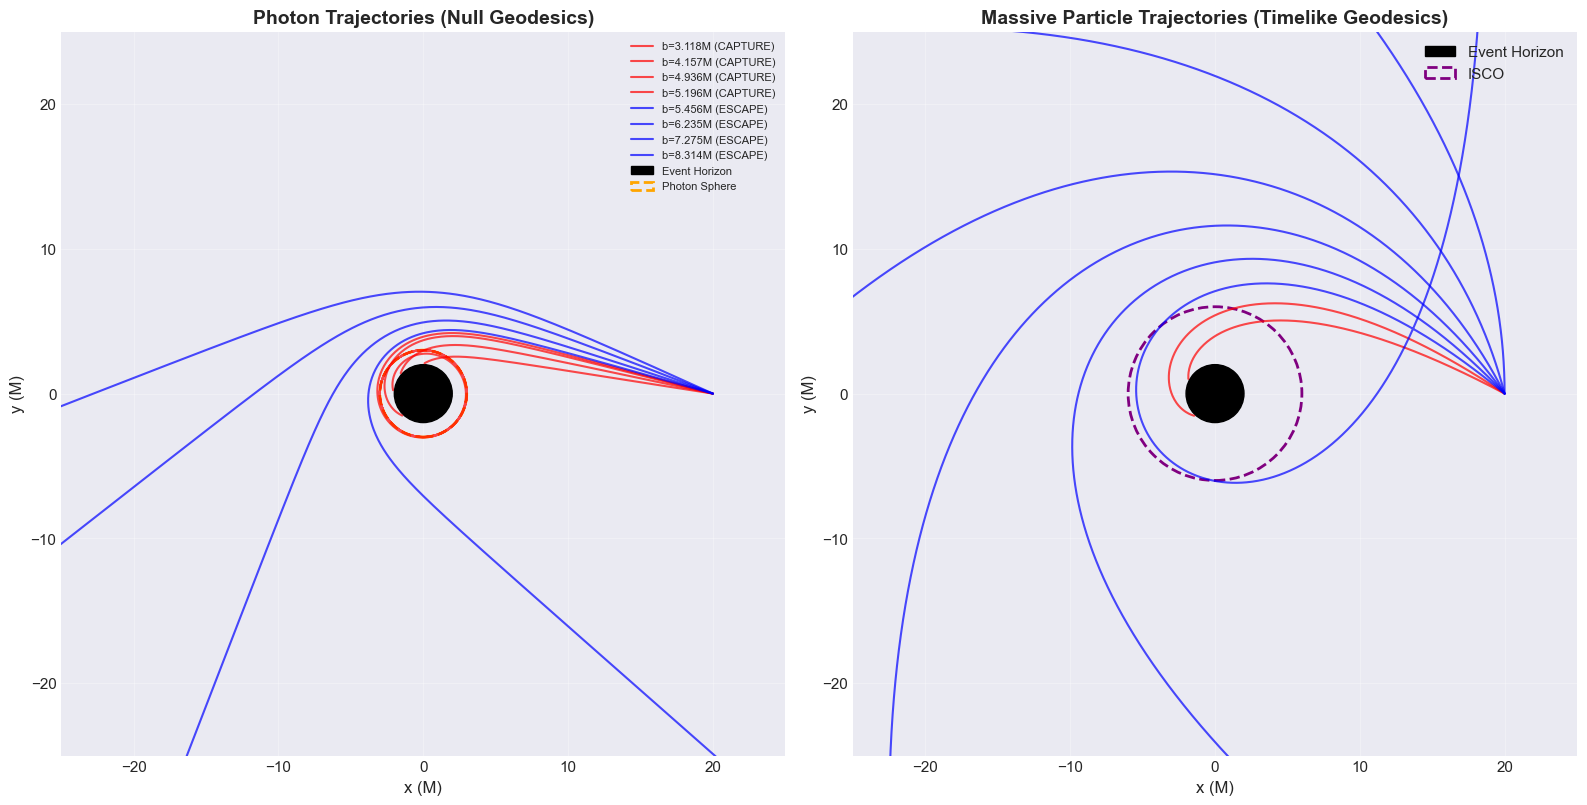


✅ Schwarzschild simulations complete!
   Photons with b < 5.196M are CAPTURED (red)
   Photons with b > 5.196M ESCAPE (blue)


In [6]:
# Plot photon and massive particle trajectories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Left: Photons ---
ax1.set_title('Photon Trajectories (Null Geodesics)', fontsize=14, fontweight='bold')

for i, traj in enumerate(trajectories_photon):
    color = 'red' if 'CAPTURE' in traj.label else 'blue'
    alpha = 0.7
    ax1.plot(traj.x, traj.y, color=color, alpha=alpha, linewidth=1.5, label=traj.label)

# Draw event horizon
horizon = Circle((0, 0), metric_sch.r_s, color='black', label='Event Horizon')
ax1.add_patch(horizon)

# Draw photon sphere
photon_sphere = Circle((0, 0), metric_sch.r_photon, color='orange', 
                       fill=False, linestyle='--', linewidth=2, label='Photon Sphere')
ax1.add_patch(photon_sphere)

ax1.set_xlim(-25, 25)
ax1.set_ylim(-25, 25)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x (M)', fontsize=12)
ax1.set_ylabel('y (M)', fontsize=12)
ax1.legend(loc='upper right', fontsize=8)

# --- Right: Massive Particles ---
ax2.set_title('Massive Particle Trajectories (Timelike Geodesics)', fontsize=14, fontweight='bold')

for i, traj in enumerate(trajectories_massive):
    if len(traj) > 0:
        if traj.r[-1] > 50:
            color = 'blue'
        elif traj.r[-1] < metric_sch.r_s * 2:
            color = 'red'
        else:
            color = 'green'
        ax2.plot(traj.x, traj.y, color=color, alpha=0.7, linewidth=1.5)

# Draw features
horizon2 = Circle((0, 0), metric_sch.r_s, color='black', label='Event Horizon')
ax2.add_patch(horizon2)

isco_circle = Circle((0, 0), metric_sch.r_isco, color='purple', 
                    fill=False, linestyle='--', linewidth=2, label='ISCO')
ax2.add_patch(isco_circle)

ax2.set_xlim(-25, 25)
ax2.set_ylim(-25, 25)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x (M)', fontsize=12)
ax2.set_ylabel('y (M)', fontsize=12)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('schwarzschild_geodesics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Schwarzschild simulations complete!")
print(f"   Photons with b < {b_crit:.3f}M are CAPTURED (red)")
print(f"   Photons with b > {b_crit:.3f}M ESCAPE (blue)")

---
## 2. Kerr Black Holes <a id="kerr-sims"></a>

The **Kerr metric** describes a rotating black hole with angular momentum $a$ (dimensionless spin $a/M \in [0, 1]$).

### Key Features

- **Two Horizons:** $r_\pm = M \pm \sqrt{M^2 - a^2}$
- **Ergosphere:** $r_{ergo} = 2M$ (at equator)
- **Frame Dragging:** Spacetime itself rotates
- **Asymmetric Orbits:** Prograde vs retrograde

### Spin Parameters

- $a/M = 0$: Schwarzschild (no rotation)
- $a/M = 0.5$: Moderate spin
- $a/M = 0.998$: Near-extremal (like M87*)

In [7]:
# Simulate Kerr black holes with different spins
print("\n" + "="*70)
print("KERR BLACK HOLE SIMULATIONS")
print("="*70)

spins = [0.0, 0.5, 0.9]
all_kerr_trajectories = {}

for spin in spins:
    print(f"\nSimulating Kerr with a/M = {spin}")
    
    metric_kerr = KerrMetric(mass=1.0, spin=spin)
    sim_kerr = GeodesicSimulation(metric_kerr)
    
    print(f"  Inner horizon r- = {metric_kerr.r_minus:.3f}M")
    print(f"  Outer horizon r+ = {metric_kerr.r_plus:.3f}M")
    print(f"  Ergosphere = {metric_kerr.r_ergo:.3f}M")
    
    # Simulate photons
    impact_params = np.linspace(3.0, 8.0, 6)
    
    trajectories = sim_kerr.simulate_bundle(
        r0=15.0,
        impact_params=impact_params,
        is_timelike=False,
        tau_span=(0, 150),
        radial_direction="inward"
    )
    
    all_kerr_trajectories[spin] = {
        'metric': metric_kerr,
        'trajectories': trajectories
    }

print("\n✅ All Kerr simulations complete!")


KERR BLACK HOLE SIMULATIONS

Simulating Kerr with a/M = 0.0
  Inner horizon r- = 0.000M
  Outer horizon r+ = 2.000M
  Ergosphere = 2.000M

Simulating photons around KerrMetric
Critical impact parameter: b_crit = 5.196 M
Initial radius: r₀ = 15.00 M
Radial direction: inward

  b=3.000M (CAPTURE)             → captured   (points: 147)
  b=4.000M (CAPTURE)             → captured   (points: 158)
  b=5.000M (CAPTURE)             → captured   (points: 193)
  b=6.000M (ESCAPE)              → escaped    (points: 1183)
  b=7.000M (ESCAPE)              → escaped    (points: 1170)
  b=8.000M (ESCAPE)              → escaped    (points: 1160)



Simulating Kerr with a/M = 0.5
  Inner horizon r- = 0.134M
  Outer horizon r+ = 1.866M
  Ergosphere = 2.000M

Simulating photons around KerrMetric
Critical impact parameter: b_crit = 5.196 M
Initial radius: r₀ = 15.00 M
Radial direction: inward

  b=3.000M (CAPTURE)             → escaped    (points: 767)
  b=4.000M (CAPTURE)             → escaped    (point

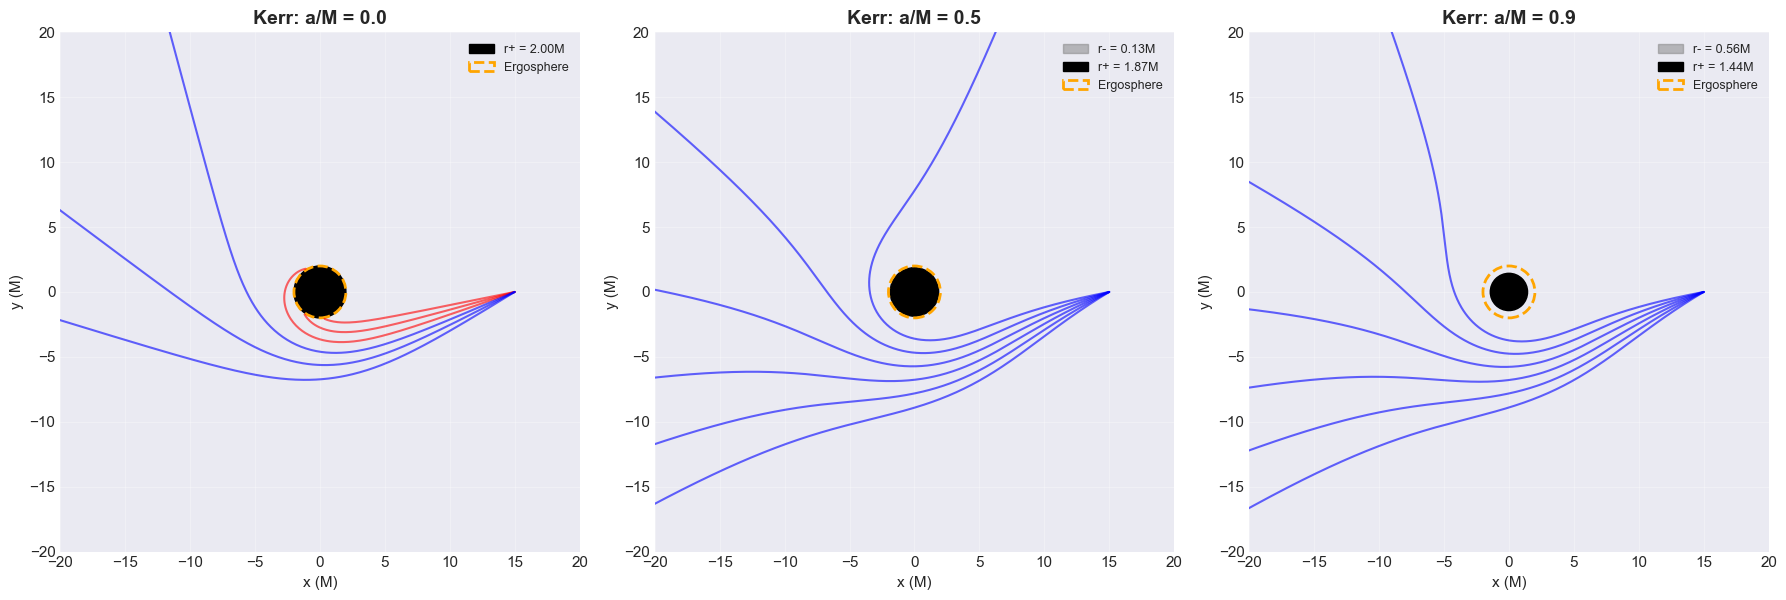


✅ Kerr comparison plot saved!


In [8]:
# Plot Kerr trajectories for different spins
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, spin in enumerate(spins):
    ax = axes[idx]
    data = all_kerr_trajectories[spin]
    metric = data['metric']
    trajectories = data['trajectories']
    
    ax.set_title(f'Kerr: a/M = {spin}', fontsize=14, fontweight='bold')
    
    # Plot trajectories
    for traj in trajectories:
        if len(traj) > 0:
            if traj.r[-1] > 40:
                color = 'blue'
            else:
                color = 'red'
            ax.plot(traj.x, traj.y, color=color, alpha=0.6, linewidth=1.5)
    
    # Draw horizons
    if spin > 0:
        inner = Circle((0, 0), metric.r_minus, color='gray', alpha=0.5, label=f'r- = {metric.r_minus:.2f}M')
        ax.add_patch(inner)
    
    outer = Circle((0, 0), metric.r_plus, color='black', label=f'r+ = {metric.r_plus:.2f}M')
    ax.add_patch(outer)
    
    ergo = Circle((0, 0), metric.r_ergo, color='orange', fill=False, 
                 linestyle='--', linewidth=2, label='Ergosphere')
    ax.add_patch(ergo)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x (M)', fontsize=11)
    ax.set_ylabel('y (M)', fontsize=11)
    ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('kerr_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Kerr comparison plot saved!")

---
## 3. Summary <a id="comparison"></a>

### Key Findings

1. **Sign Error Fixed**: The centrifugal term in the geodesic equation must be **positive** to represent outward force
2. **Critical Impact Parameter**: For Schwarzschild photons, $b_{crit} = \sqrt{27}M \approx 5.196M$
3. **Capture vs Escape**: 
   - $b < b_{crit}$: Photon is captured
   - $b > b_{crit}$: Photon escapes
4. **Kerr Effects**: Rotation changes horizon structure and creates ergosphere

### Physical Insights

- Photons follow null geodesics ($ds^2 = 0$)
- Massive particles follow timelike geodesics ($ds^2 < 0$)
- Frame dragging in Kerr spacetime creates asymmetric orbits
- Energy can be extracted from rotating black holes (Penrose process)

---

**End of Notebook**